<a href="https://colab.research.google.com/github/zwubbena/sample-size-table/blob/main/sample_size_table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

▶ Processing Scenario A (80%, ±13%)...
▶ Processing Scenario B (80%, ±12%)...
▶ Processing Scenario C (80%, ±11%)...
▶ Creating line graph...


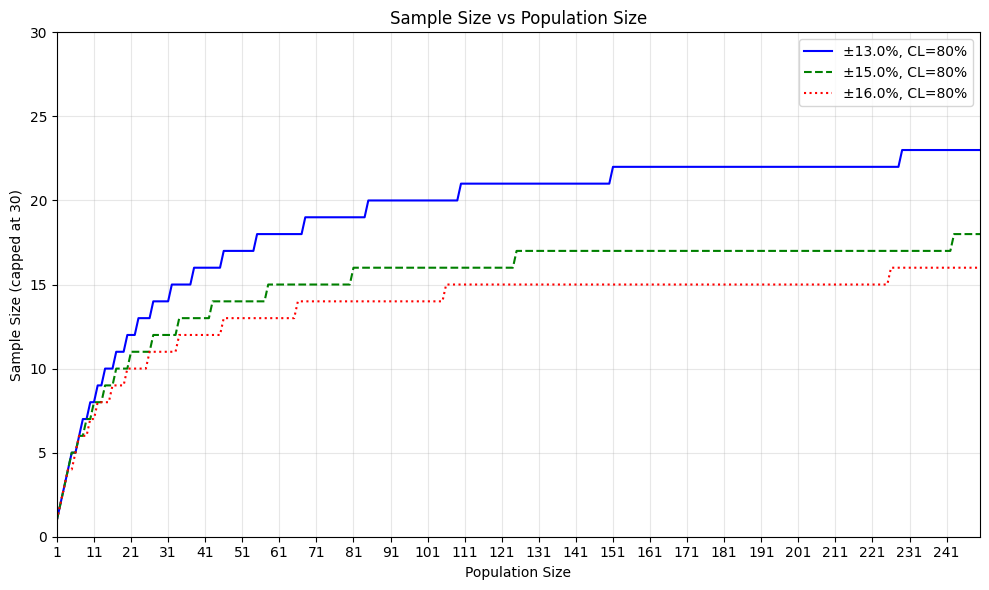

▶ Exporting to Excel...
✓ Excel file created: /content/sample_size_output.xlsx

Sample size analysis completed successfully!
View graph above or download:
Excel: /content/sample_size_output.xlsx
Graph: /content/inline_plot.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# =============================================================================
# Script Name : sample_size_analysis.ipynb
# Purpose     : Calculate and visualize sample size tables for known populations
# Author      : Zane Wubbena, PhD
# Agency      : Texas Education Agency (TEA)
# Platform    : Google Colab
# Last Updated: 2025-07-24
# =============================================================================

# =============================================================================
# SECTION 1: Import Required Libraries
# =============================================================================

import os
import math
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from matplotlib.lines import Line2D
!pip install -q xlsxwriter

# =============================================================================
# SECTION 2: User-Defined Parameters
# =============================================================================

# --- Scenario Control ---
RUN_SINGLE = False  # Set True to run only one scenario
SINGLE_SCENARIO_INDEX = 0  # Index of scenario to run if RUN_SINGLE = True

# --- Display Settings ---
POP_MIN = 1             # Graph display min
POP_MAX = 250           # Graph display max
# POP_MAX_ALL = 20000   # Total population range
SAMPLE_CAP = 30         # Max sample size to show
X_TICK_INTERVAL = 10
Y_TICK_INTERVAL = 5
OUTPUT_DIR = "/content/"

# --- Scenarios List ---
SCENARIOS = [
    {
        "Name": "Scenario A (80%, ±13%)",
        "Z": 1.28,
        "Margin": 0.13,
        "Proportion": 0.50,
        "LineStyle": "-",
        "LineColor": "blue",
    },
    {
        "Name": "Scenario B (80%, ±12%)",
        "Z": 1.28,
        "Margin": 0.15,
        "Proportion": 0.50,
        "LineStyle": "--",
        "LineColor": "green",
    },
    {
        "Name": "Scenario C (80%, ±11%)",
        "Z": 1.28,
        "Margin": 0.16,
        "Proportion": 0.50,
        "LineStyle": ":",
        "LineColor": "red",
    },
]

# Common z-score references for documentation
#  Z = 1.28  → 80% Confidence
#  Z = 1.645 → 90% Confidence
#  Z = 1.96  → 95% Confidence
#  Z = 2.576 → 99% Confidence

# =============================================================================
# SECTION 3: Sample Size Calculation Function
# =============================================================================

def calculate_sample_size(N, e, p, z):
    """
    Calculate sample size with finite population correction.
    """
    if N < 1:
        raise ValueError("Population must be >= 1")

    numerator = (z ** 2) * p * (1 - p)
    denominator = e ** 2
    n_0 = numerator / denominator
    adjusted_n = n_0 / (1 + ((n_0 - 1) / N))
    return min(math.ceil(adjusted_n), N)

# =============================================================================
# SECTION 4: Run All or Single Scenario(s)
# =============================================================================

scenarios_to_run = [SCENARIOS[SINGLE_SCENARIO_INDEX]] if RUN_SINGLE else SCENARIOS
plot_df = pd.DataFrame()
scenario_summary = []

for scenario in scenarios_to_run:
    name = scenario["Name"]
    z = scenario["Z"]
    e = scenario["Margin"]
    p = scenario["Proportion"]

    print(f"▶ Processing {name}...")

    # Generate full sample size dataset
    df = pd.DataFrame({
        "Population_Size": range(1, 20001)
    })
    df["Sample_Size"] = df["Population_Size"].apply(lambda N: calculate_sample_size(N, e, p, z))
    df["Truncated_Sample_Size"] = df["Sample_Size"].apply(lambda x: min(x, SAMPLE_CAP))

    # Group population ranges by sample size
    grouped = df.groupby("Sample_Size")["Population_Size"].agg(["min", "max"]).reset_index()
    grouped["Population_Range"] = grouped.apply(
        lambda row: f"{row['min']}" if row["min"] == row["max"]
        else f"{row['min']}-{row['max']}", axis=1
    )
    grouped = grouped[["Sample_Size", "Population_Range"]]

    # Save summary info
    confidence = round(2 * stats.norm.cdf(z) - 1, 4)
    max_sample = df["Sample_Size"].max()
    scenario_summary.append({
        "Scenario": name,
        "Z-Score": z,
        "Confidence_Level": f"{confidence*100:.1f}%",
        "Margin_of_Error": f"±{e*100:.1f}%",
        "Max_Sample_Size": max_sample
    })

    # Save plot-specific data
    temp = df[df["Population_Size"].between(POP_MIN, POP_MAX)].copy()
    temp["Scenario"] = name
    temp["LineStyle"] = scenario["LineStyle"]
    temp["LineColor"] = scenario["LineColor"]
    plot_df = pd.concat([plot_df, temp], ignore_index=True)

    # Save grouped range data for Excel
    scenario["DataFrame_Grouped"] = grouped

# =============================================================================
# SECTION 5: Create Line Graph in Google Colab
# =============================================================================

print("▶ Creating line graph...")
plt.figure(figsize=(10, 6))

for scenario in scenarios_to_run:
    temp = plot_df[plot_df["Scenario"] == scenario["Name"]]

    # Dynamically calculate label for legend
    confidence_level = 2 * stats.norm.cdf(scenario["Z"]) - 1
    label = f"±{scenario['Margin']*100:.1f}%, CL={round(confidence_level * 100)}%"


    # Plot each scenario
    plt.plot(
        temp["Population_Size"],
        temp["Truncated_Sample_Size"],
        label=label,
        linestyle=scenario["LineStyle"],
        color=scenario["LineColor"],
        linewidth=1.5
    )

plt.xlabel("Population Size")
plt.ylabel(f"Sample Size (capped at {SAMPLE_CAP})")
plt.title("Sample Size vs Population Size")
plt.xticks(range(POP_MIN, POP_MAX+1, X_TICK_INTERVAL))
plt.yticks(range(0, SAMPLE_CAP+1, Y_TICK_INTERVAL))
plt.ylim(0, SAMPLE_CAP)
plt.xlim(POP_MIN, POP_MAX)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()

# Save plot image
graph_path = os.path.join(OUTPUT_DIR, "inline_plot.png")
plt.savefig(graph_path, dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# SECTION 6: Export to Excel
# =============================================================================

print("▶ Exporting to Excel...")
excel_path = os.path.join(OUTPUT_DIR, "sample_size_output.xlsx")
summary_df = pd.DataFrame(scenario_summary)

with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:

    # Sheet: Scenario Summary + Graph
    summary_df.to_excel(writer, sheet_name="Scenario Summary", index=False)
    workbook = writer.book
    summary_ws = writer.sheets["Scenario Summary"]
    summary_ws.set_column('A:E', 20)

    if os.path.exists(graph_path):
        summary_ws.insert_image("G2", graph_path, {"x_scale": 0.8, "y_scale": 0.8})

    # Sheets: Grouped Sample Size Ranges
    for scenario in scenarios_to_run:
        sheet_name = scenario["Name"].split()[1]  # e.g., "A", "B", "C"
        grouped = scenario["DataFrame_Grouped"]
        grouped.to_excel(writer, sheet_name=f"Section B - {sheet_name}", index=False)

        ws = writer.sheets[f"Section B - {sheet_name}"]
        ws.set_column('A:B', 25)

        # Insert same graph at the bottom of each scenario sheet
        if os.path.exists(graph_path):
            last_row = len(grouped) + 3
            ws.insert_image(f"A{last_row}", graph_path, {"x_scale": 0.8, "y_scale": 0.8})

print(f"✓ Excel file created: {excel_path}")

# =============================================================================
# SECTION 7: Completion Message
# =============================================================================

print("\n" + "="*60)
print("Sample size analysis successfully completed!")
print("="*60)
print(f"View graph above or download:")
print(f"Excel: {excel_path}")
print(f"Graph: {graph_path}")

# Automatically download file to computer
from google.colab import files
files.download(excel_path)

# =============================================================================
# Python Program End
# =============================================================================